In [41]:
using JuMP, Gurobi, Random, CSV, DataFrames, Statistics, JLD2, FileIO, DelimitedFiles,Printf,Suppressor

model_type="model_without_k";
include("2_scripts/"*model_type*"/display.jl"); include("2_scripts/"*model_type*"/model.jl"); include("2_scripts/"*model_type*"/benders_model.jl");include("2_scripts/"*model_type*"/run.jl"); include("1_data/map_config.jl");

In [42]:
# Benchmarks definition
b1=Dict("Name"=> "1)", "Transfer"=> false, "Flexible" => false, "High capacity" => false);
b2=Dict("Name"=> "2)", "Transfer"=> false, "Flexible" => false, "High capacity" => true); # We take high capacity busses
b3=Dict("Name"=> "3)", "Transfer"=> false, "Flexible" => true, "High capacity" => true); # We take high capacity busses + Flexible assign
b4=Dict("Name"=> "4)", "Transfer"=> true, "Flexible" => true, "High capacity" => true); # We take high capacity busses + Flexible assign + Transfer

### Inputs

In [43]:
# Map Inputs
map_type="unif_map_1";

# Model Inputs
benchmark=b4;
G = 2 # max detour ratio for customers (traveling time < (1+G)gamma)
Gtype= "shortestpathpercent" # or "absolutetime"

map_inputs,Wk,Q=create_inputs(map_type,benchmark); 
(map_title,_,_,nb_locs,_,nb_cust,_,horizon,tstep,_)=map_inputs; #hiding some outputs since locs numbers will be updated
model_inputs = (G,Gtype,Wk,Q);

### Display map & create network

In [44]:
data, map1, tsnetwork, params, abbrev, pre_time = create_network(map_inputs, model_inputs,benchmark);
q, t, I, K=abbrev;

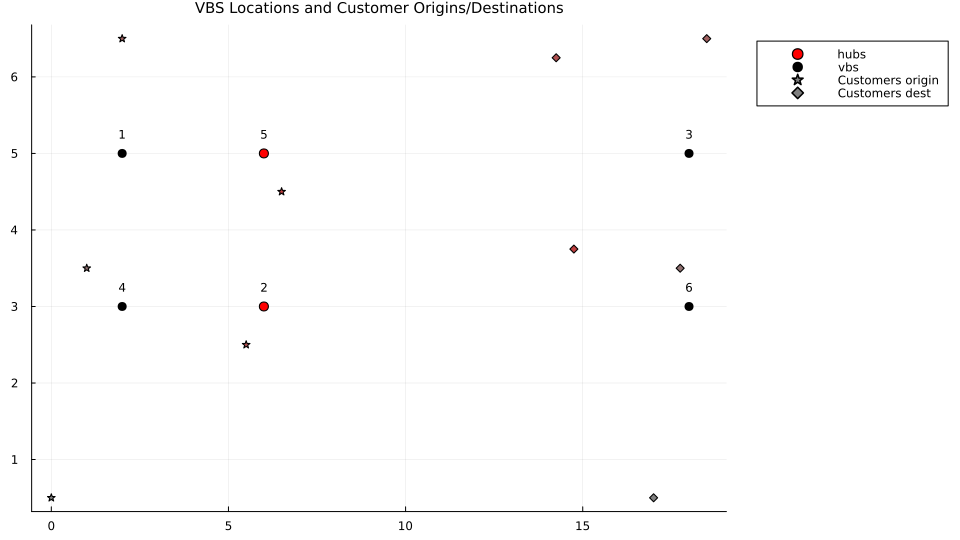

Cust 1, load 1 - Pick-up vbs: [4], Drop-off vbs: [6], 	 depart at: 0.0, arrival before: 60
Cust 2, load 1 - Pick-up vbs: [1, 4], Drop-off vbs: [3, 6], 	 depart at: 10.0, arrival before: 60
Cust 3, load 1 - Pick-up vbs: [1, 4], Drop-off vbs: [3, 6], 	 depart at: 20.0, arrival before: 60
Cust 4, load 1 - Pick-up vbs: [2, 4, 5], Drop-off vbs: [3], 	 depart at: 5.0, arrival before: 60
Cust 5, load 1 - Pick-up vbs: [2, 5], Drop-off vbs: [3, 6], 	 depart at: 15.0, arrival before: 60
Bus depot locations: Any[1, 4]

In [45]:
# Show map
display(map1)
print_cust_bus_details(params,abbrev,data.locs_id)

In [6]:
# save figure map1
#savefig(map1,"1_data/map_cluster_BIG/map.png")

# To visualize some arcs
#timespaceviz_arcs("viz.png", horizon, tstep, tsnetwork, params.A,data.locs_id,data.locs_desc, x_size=2000, y_size=1000)

### Run model & Save results

In [47]:
# Model objective coefficients
alpha2 = 5 #course price 
alpha1 = 0.1 #variable service cost (price per min) 
alpha0 = 5 #fixed service cost (price per vehicle used) 
mu = 0.1 # Cost of 1min cust walking 
beta = 0.05 #Cost of 1min cust waiting 
delta = 0.01 #Cost of 1mn cust traveling in bus 
lambda = 1 #Cost of cust transfers 

coefficients=alpha2, alpha1, alpha0, mu, beta, delta, lambda;

In [48]:
# Direct solve
direct_sol=network_model_profit(Q,abbrev,data.wo,tsnetwork,params,coefficients,0);

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04
Set parameter MIPGap to value 0.1
Objective value: -0.0


In [9]:
direct_sol.objs

Dict{String, Float64} with 7 entries:
  "Cust driving" => 107.92
  "Wait"         => 36.84
  "Veh_nb"       => 1.0
  "Served"       => 4.0
  "Veh driving"  => 34.69
  "Tr"           => 0.0
  "Walk"         => 48.35

In [94]:
#map_sol=print_traveling_arcs(direct_sol,0,map1,data.locs,tsnetwork,params,horizon,data.locs_id,data.locs_desc,true,false,0)

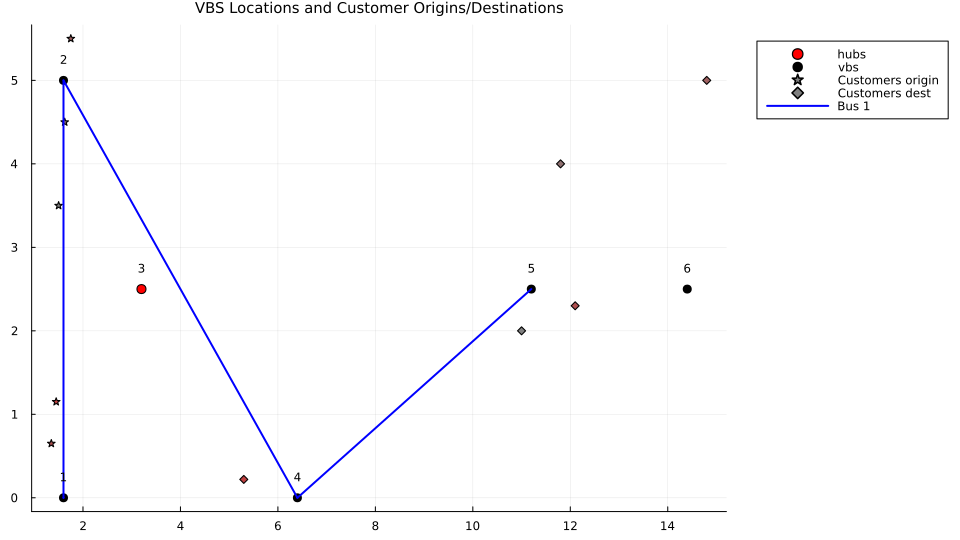

In [10]:
save_res=true
if save_res
    benchmark_name=string(benchmark["Name"])*"Tr_"*string(benchmark["Transfer"])*"_Flex_"*string(benchmark["Flexible"])*"_HighCap_"*string(benchmark["High capacity"])
    resultfolder="3_results/"*model_type*"/"*map_type*"/"*benchmark_name*"/";
    if !isdir("3_results/"*model_type*"/"*map_type*"/")
        mkdir("3_results/"*model_type*"/"*map_type*"/")
    end
    if !isdir(resultfolder)
        mkdir(resultfolder)
    end
    jldsave(resultfolder*"solution.jld2", xi=direct_sol.xi, x=direct_sol.x, z=direct_sol.z)
    write_result(resultfolder*"res.txt",direct_sol,tsnetwork,params,abbrev,data.wo,data.locs_id,false)
end

timespaceviz_bus(resultfolder*"tsplot.png", horizon, tstep, tsnetwork, params, direct_sol.z, data.locs_id, data.locs_desc,x_size=2000, y_size=1000)
ts=0 # time from which we want to print the arcs
map2=print_traveling_arcs(direct_sol,0,map1,data.locs,tsnetwork,params,horizon,data.locs_id,data.locs_desc,false,save_res,resultfolder)

### Solve Benders model with Pareto optimality cuts

Solve benders by giving the optimal z after the 1st iter

In [11]:
include("2_scripts/"*model_type*"/benders_model.jl")
sol_benders_fix,benders_prop_fix=solve_benders_profit_zfix(direct_sol.z,Q,abbrev,data,tsnetwork,params,coefficients,true,60);

Looking for a core point z0...


Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04
Core point found !


Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04
Set parameter TimeLimit to value 60
Set parameter MIPGap to value 0.001

 Iteration 1
Set parameter MIPGap to value 0.001
Set parameter TimeLimit to value 60
Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04


Set parameter MIPGap to value 0.001
Set parameter DualReductions to value 0
Set parameter InfUnbdInfo to value 1
-------------------
sum lambda 2636.8919141108317
sum epsilon 0.0
sum iota 0.0
SP primal obj -0.0, SP dual obj 0.0


Dict

("Cust driving" => 0.0, "Wait" => 0.0, "Veh_nb" => 0.0, "Served" => 0.0, "Veh driving" => 0.0, "Tr" => 0.0, "Walk" => 0.0)


Sol: 0.00 - Upper Bound: 1000000000000000019884624838656.00 


 Iteration 2
Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04


Set parameter MIPGap to value 0.001
Set parameter DualReductions to value 0
Set parameter InfUnbdInfo to value 1
-------------------
sum lambda 2013.098179220386
sum epsilon 0.0
sum iota 0.0
SP primal obj 12.24, SP dual obj 12.24
Dict("Cust driving" => 107.92, "Wait" => 36.84, "Veh_nb" => 1.0, "Served" => 4.0, "Veh driving" => 34.69, "Tr" => 0.0, "Walk" => 48.35)
Sol: 3.78 - Upper Bound: 39.21 


 Iteration 3
Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04


Set parameter MIPGap to value 0.001
Set parameter DualReductions to value 0
Set parameter InfUnbdInfo to value 1
-------------------
sum lambda 2013.098179220386
sum epsilon 0.0
sum iota 0.0
SP primal obj 12.24, SP dual obj 12.24
Dict("Cust driving" => 107.92, "Wait" => 36.84, "Veh_nb" => 1.0, "Served" => 4.0, "Veh driving" => 34.69, "Tr" => 0.0, "Walk" => 48.35)
Sol: 3.78 - Upper Bound: 3.78 

Optimality gap reached
Objective value: 3.775203327795275


In [12]:
sol_benders_fix.objs

Dict{String, Float64} with 7 entries:
  "Cust driving" => 107.92
  "Wait"         => 36.84
  "Veh_nb"       => 1.0
  "Served"       => 4.0
  "Veh driving"  => 34.69
  "Tr"           => 0.0
  "Walk"         => 48.35

Solve full benders

In [13]:
include("2_scripts/"*model_type*"/benders_model.jl")
sol_benders,benders_prop=solve_benders_profit(Q,abbrev,data,tsnetwork,params,coefficients,true,1200);

Looking for a core point z0...
Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04
Core point found !


Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04
Set parameter TimeLimit to value 1200
Set parameter MIPGap to value 0.001

 Iteration 1
Set parameter MIPGap to value 0.001
Set parameter TimeLimit to value 1200
Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04


Set parameter MIPGap to value 0.001
Set parameter DualReductions to value 0
Set parameter InfUnbdInfo to value 1
-------------------
sum lambda 2636.8919141108317
sum epsilon 0.0
sum iota 0.0
SP primal obj -0.0, SP dual obj 0.0


Dict("Cust driving" => 0.0, "Wait" => 0.0, "Veh_nb" => 0.0, "Served" => 0.0, "Veh driving" => 0.0, "Tr" => 0.0, "Walk" => 0.0)
Sol: 0.00 - Upper Bound: 1000000000000000019884624838656.00 


 Iteration 2
Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04


Set parameter MIPGap to value 0.001
Set parameter DualReductions to value 0
Set parameter InfUnbdInfo to value 1
-------------------
sum lambda 893.2270136374929
sum epsilon 5.007201301420014
sum iota 3.827581014816548
SP primal obj 6.4, SP dual obj 6.4
Dict("Cust driving" => 56.84, "Wait" => 38.19, "Veh_nb" => 2.0, "Served" => 3.0, "Veh driving" => 85.69, "Tr" => 0.0, "Walk" => 61.26)
Sol: -12.17 - Upper Bound: 244.98 


 Iteration 3
Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04


Set parameter MIPGap to value 0.001
Set parameter DualReductions to value 0
Set parameter InfUnbdInfo to value 1
-------------------
sum lambda 902.1705569386812
sum epsilon 7.791784643095272
sum iota 4.427581014816548
SP primal obj 10.11, SP dual obj 10.11
Dict("Cust driving" => 81.38, "Wait" => 54.76, "Veh_nb" => 2.0, "Served" => 4.0, "Veh driving" => 72.23, "Tr" => 0.0, "Walk" => 63.43)
Sol: -7.12 - Upper Bound: 45.83 


 Iteration 4
Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04


Set parameter MIPGap to value 0.001
Set parameter DualReductions to value 0
Set parameter InfUnbdInfo to value 1
-------------------
sum lambda 866.9075150264273
sum epsilon 5.166848605086676
sum iota 4.427581014816548
SP primal obj 10.05, SP dual obj 10.05
Dict("Cust driving" => 87.38, "Wait" => 54.76, "Veh_nb" => 2.0, "Served" => 4.0, "Veh driving" => 88.23, "Tr" => 0.0, "Walk" => 63.43)
Sol: -8.78 - Upper Bound: 43.89 


 Iteration 5
Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04


Set parameter MIPGap to value 0.001
Set parameter DualReductions to value 0
Set parameter InfUnbdInfo to value 1
-------------------
sum lambda 383.28815901932506
sum epsilon 0.0
sum iota 6.034293166088217
SP primal obj 7.38, SP dual obj 7.38
Dict("Cust driving" => 48.0, "Wait" => 20.19, "Veh_nb" => 2.0, "Served" => 3.0, "Veh driving" => 78.7, "Tr" => 0.0, "Walk" => 61.26)
Sol: -10.49 - Upper Bound: 39.41 

Objective value: -10.485316987571373


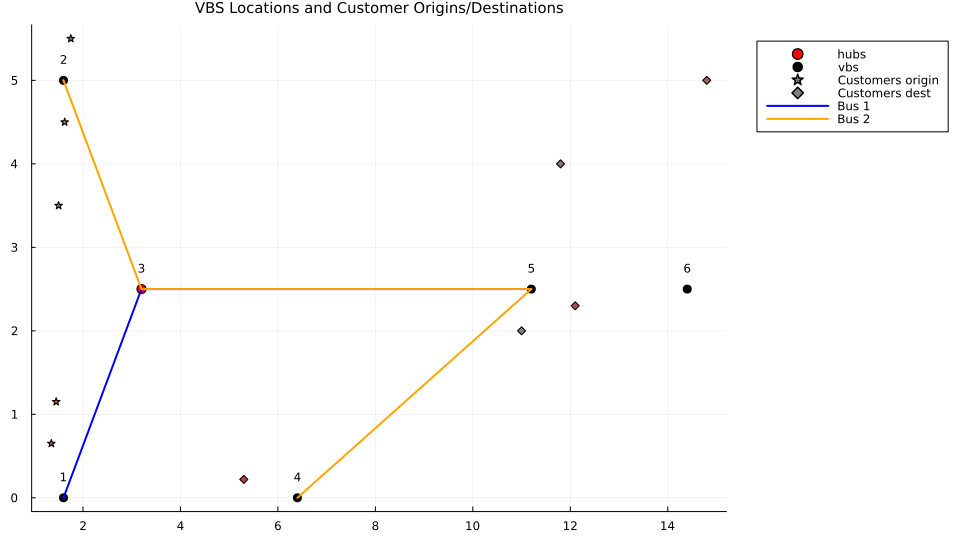

In [14]:
map_test=print_traveling_arcs(sol_benders,0,map1,data.locs,tsnetwork,params,horizon,data.locs_id,data.locs_desc,false,false,"test")

# Save solution

In [100]:
include("2_scripts/"*model_type*"/display.jl")
save_res = false; # to save the results in the result folder
print_all = false; # to print all the arcs traveled by buses
model_type_results="benders"
solution=sol_benders
b_res=benders_prop # or nothing

map2bis, plot_bounds, plot_times= save_and_display(map1, model_type_results,map_type,benchmark,save_res,solution,horizon,tstep,tsnetwork,params,abbrev,data,print_all,b_res);

### Visualizations

In [18]:
#xi,x,z=load(resultfolder*"solution.jld2", "xi", "x", "z");

In [19]:
#timespaceviz_arcs(resultfolder*"arcsplot.png",horizon, tstep, tsnetwork, params.Ai[1], data.locs_id,data.locs_desc; x_size=2000, y_size=1000)

In [20]:
#timespaceviz_bus(resultfolder*"tsplot.png", horizon, tstep, tsnetwork, params, sol.z, data.locs_id, data.locs_desc,x_size=2000, y_size=1000)

In [21]:
#ts=0 # time from which we want to print the arcs
#map2=print_traveling_arcs(sol,ts,map1,data.locs,tsnetwork,params,horizon,data.locs_id,data.locs_desc,true,save_res,resultfolder)